#### Alternative Approach to Analyzing this Data
- Visualizing the Sound Waves

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import sys
if hasattr(sys, 'argv'):
    sys.argv.append('-Xfrozen_modules=off')

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import wave
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [ ]:
base_url = '/content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/'
file_path = base_url + 'data/record_audio008.txt' # path to data file
data = np.genfromtxt(file_path, delimiter=',', dtype=str)
data = np.array(data)
print(data)

# need to find the clapping time frame in the video data
clap_ts_in_data = 1744574766.714497

[['1' '1744574770.154879' '1744574775.186158' 'Aluminium Metal']
 ['6' '1744574775.191911' '1744574779.237463' 'collect-Aluminium Metal']
 ['2' '1744574779.237875' '1744574784.259585' 'Bark Wood']
 ['7' '1744574784.259984' '1744574788.263979' 'collect-Bark Wood']
 ['0' '1744574788.264293' '1744574793.295406' 'Textile']
 ['5' '1744574793.295785' '1744574797.310681' 'collect-Textile']
 ['3' '1744574797.311126' '1744574802.338442' 'PLA plastic']
 ['8' '1744574802.338793' '1744574806.376179' 'collect-PLA plastic']
 ['4' '1744574806.376566' '1744574811.385519' 'Table']
 ['9' '1744574811.385987' '1744574815.387891' 'collect-Table']
 ['2' '1744574815.388325' '1744574820.419842' 'Bark Wood']
 ['7' '1744574820.420268' '1744574824.445756' 'collect-Bark Wood']
 ['1' '1744574824.446078' '1744574829.450299' 'Aluminium Metal']
 ['6' '1744574829.450748' '1744574833.463093' 'collect-Aluminium Metal']
 ['0' '1744574833.463543' '1744574838.488647' 'Textile']
 ['5' '1744574838.489021' '1744574842.534203'

In [ ]:
raw_file_path = base_url + 'data/audio008.raw'
wav_file_path = base_url + 'audio008.wav'


sample_rate = 96000  # From config.json
bit_depth = 16       # From config.json
num_channels = 1   # From config.json


dtype = np.int16 if bit_depth == 16 else np.int8
audio_data = np.fromfile(raw_file_path, dtype=dtype)


with wave.open(wav_file_path, 'wb') as wav_file:
   wav_file.setnchannels(num_channels)
   wav_file.setsampwidth(bit_depth // 8)
   wav_file.setframerate(sample_rate)
   wav_file.writeframes(audio_data.tobytes())


print(f"Converted {raw_file_path} to {wav_file_path}")

Converted /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/data/audio008.raw to /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio008.wav


In [ ]:
wav_obj = wave.open(wav_file_path, 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
print(f'Sample Frequency: {sample_freq}, Number of Samples: {n_samples}')

Sample Frequency: 96000, Number of Samples: 190544896


In [ ]:
signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
mono_channel = signal_array
t_audio = n_samples/sample_freq

In [ ]:
times = np.linspace(0, n_samples/sample_freq, num=n_samples)
print(times[-1])

1984.8426666666667


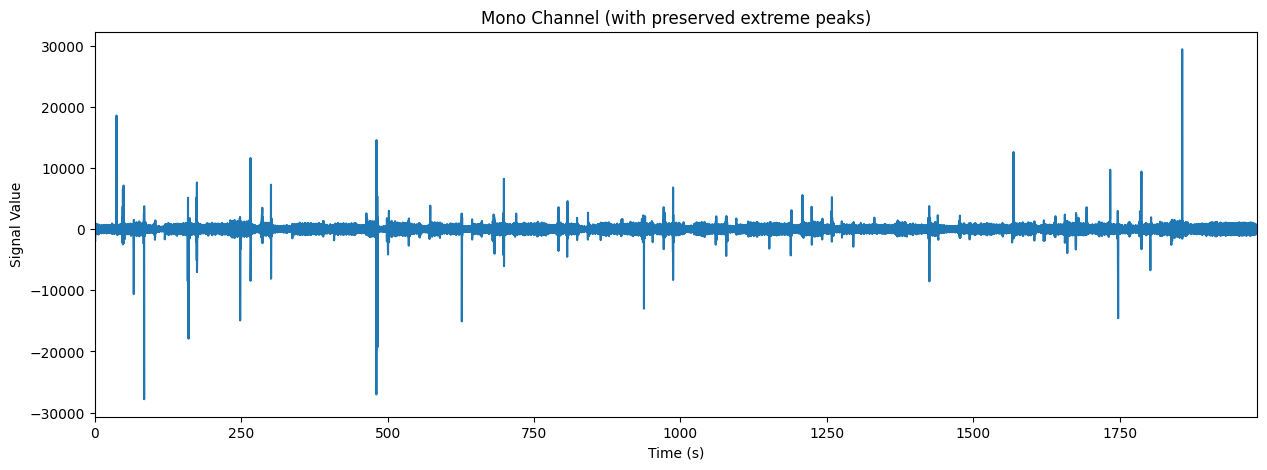

In [ ]:
def downsample_preserve_extreme_peaks(signal, times, factor, threshold=20000):
    """
    Downsample signal while preserving extreme peaks above threshold

    Parameters:
    signal: audio signal array
    times: corresponding time points
    factor: downsampling factor
    threshold: amplitude threshold to consider as peak (default 20000)
    """
    result_signal = []
    result_times = []

    # First, find ALL points exceeding threshold
    extreme_indices = np.where(np.abs(signal) > threshold)[0]
    extreme_set = set(extreme_indices)

    # Process in chunks for regular downsampling
    for i in range(0, len(signal), factor):
        chunk_end = min(i+factor, len(signal))
        chunk = signal[i:chunk_end]

        if len(chunk) > 0:
            # Check if this chunk contains extreme peaks
            chunk_indices = set(range(i, chunk_end))
            extreme_in_chunk = chunk_indices.intersection(extreme_set)

            if extreme_in_chunk:
                # If chunk has extreme points, include all of them
                for idx in sorted(extreme_in_chunk):
                    result_signal.append(signal[idx])
                    result_times.append(times[idx])
            else:
                # Otherwise just take max amplitude point as before
                max_idx = i + np.argmax(np.abs(chunk))
                result_signal.append(signal[max_idx])
                result_times.append(times[max_idx])

    return np.array(result_times), np.array(result_signal)

# Calculate appropriate downsample factor
downsample_factor = max(1, len(mono_channel) // 10000)

# Get downsampled data with extreme peaks preserved
ds_times, ds_mono = downsample_preserve_extreme_peaks(
    mono_channel, times, downsample_factor, threshold=20000
)

# Plot with peak-preserving downsampling
plt.figure(figsize=(15, 5))
plt.plot(ds_times, ds_mono)
plt.title('Mono Channel (with preserved extreme peaks)')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(times[0], times[-1])
plt.show()

In [ ]:
mask = np.abs(signal_array) > 20000

# Find indices where condition is met
spike_indices = np.where(mask)[0]

if len(spike_indices) > 0:
    first_spike_index = spike_indices[0]
    last_spike_index = spike_indices[-1]

    # Calculate timestamps
    first_spike_ts = first_spike_index / sample_freq
    last_spike_ts = last_spike_index / sample_freq

    print(f"First spike at index {first_spike_index}, time {first_spike_ts}")
    print(f"Last spike at index {last_spike_index}, time {last_spike_ts}")

    # Adjust your data timestamps based on first spike
    # Subtracting clap_ts_in_data and adding clap_ts_in_wav
    data[:,1] = data[:,1].astype(float) - clap_ts_in_data + first_spike_ts
    data[:,2] = (data[:,2].astype(float) - clap_ts_in_data) + first_spike_ts
else:
    print("No spikes above threshold found")

print(data)


First spike at index 8092150, time 84.29322916666666
Last spike at index 178238731, time 1856.6534479166667
[['1' '87.73361117045084' '92.76489001909891' 'Aluminium Metal']
 ['6' '92.77064305941263' '96.8161950747172' 'collect-Aluminium Metal']
 ['2' '96.81660706202189' '101.83831698099772' 'Bark Wood']
 ['7' '101.83871609369913' '105.84271103541056' 'collect-Bark Wood']
 ['0' '105.84302503267924' '110.87413818041483' 'Textile']
 ['5' '110.87451702753702' '114.88941318194071' 'collect-Textile']
 ['3' '114.88985807100931' '119.91717416445414' 'PLA plastic']
 ['8' '119.91752511660258' '123.95491105715433' 'collect-PLA plastic']
 ['4' '123.95529801050822' '128.96425110499064' 'Table']
 ['9' '128.9647191206614' '132.96662313143412' 'collect-Table']
 ['2' '132.96705705324808' '137.99857408205668' 'Bark Wood']
 ['7' '137.99900013605753' '142.0244880358378' 'collect-Bark Wood']
 ['1' '142.02481013933817' '147.02903110186259' 'Aluminium Metal']
 ['6' '147.02948004404703' '151.04182511965433' '

In [ ]:
#update the time frames in the data file
index_w_collection = [6, 8, 5, 7]
collection_data = data[np.isin(data[:, 0].astype(int), index_w_collection)]


labels_of_interest = [
   "collect-Aluminium Metal",
   "collect-PLA plastic",
   "collect-Textile",
   "collect-Bark Wood"
]


selected_examples = []
seen_labels = set()


# Randomly select one example for each label of interest
selected_examples = []
for label in labels_of_interest:
   matching_rows = collection_data[collection_data[:, 3] == label]
   if matching_rows.size > 0:
       random_row = matching_rows[random.randint(0, len(matching_rows) - 1)]
       selected_examples.append(random_row)


diff_labels = np.array(selected_examples)
diff_labels


filtered_data = data[np.isin(data[:, 3], labels_of_interest)]


In [ ]:
filtered_data

array([['6', '92.77064305941263', '96.8161950747172',
        'collect-Aluminium Metal'],
       ['7', '101.83871609369913', '105.84271103541056',
        'collect-Bark Wood'],
       ['5', '110.87451702753702', '114.88941318194071',
        'collect-Textile'],
       ['8', '119.91752511660258', '123.95491105715433',
        'collect-PLA plastic'],
       ['7', '137.99900013605753', '142.0244880358378',
        'collect-Bark Wood'],
       ['6', '147.02948004404703', '151.04182511965433',
        'collect-Aluminium Metal'],
       ['5', '156.06775314013163', '160.11293512980143',
        'collect-Textile'],
       ['7', '165.14011699358622', '169.18393904368082',
        'collect-Bark Wood'],
       ['5', '174.2195289770762', '178.2546101252238', 'collect-Textile'],
       ['7', '183.2839661280314', '187.3116191069285',
        'collect-Bark Wood'],
       ['6', '192.31457811991373', '196.31613618532816',
        'collect-Aluminium Metal'],
       ['5', '201.31913000742594', '205.32109

In [ ]:
def save_array_to_csv(array, output_file, column_names=None):
   """
   Convert a NumPy array or filtered array to CSV

   Parameters:
   array: The array to save (NumPy array or similar)
   output_file (str): Path where the CSV will be saved
   column_names (list, optional): List of column names for the CSV
   """
   # Convert to DataFrame for easier CSV handling
   if column_names is not None:
       df = pd.DataFrame(array, columns=column_names)
   else:
       df = pd.DataFrame(array)

   # Save to CSV
   df.to_csv(output_file, index=False)
   print(f"Data successfully saved to {output_file}")



In [ ]:
save_array_to_csv(filtered_data, base_url + "audio008.csv", ["index", "Start ts", "End ts", "Label"])

Data successfully saved to /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio008.csv


In [ ]:
def plot_sound_selected(selected_examples):
    """
    Plot the sound for the selected examples.
    """

    times = np.linspace(0, n_samples / sample_freq, num=n_samples)

    for record in selected_examples:
        label = record[3]
        start_time = float(record[1])
        end_time = float(record[2])

        # Mask just for this record
        record_mask = (times >= start_time) & (times <= end_time)
        trimmed_times = times[record_mask]
        trimmed_m_channel = mono_channel[record_mask]

        plt.figure(figsize=(15, 5))
        plt.plot(trimmed_times, trimmed_m_channel)
        plt.title(f'Mono Channel - {label}')
        plt.ylabel('Signal Value')
        plt.xlabel('Time (s)')
        plt.xlim(trimmed_times[0], trimmed_times[-1])
        plt.show()


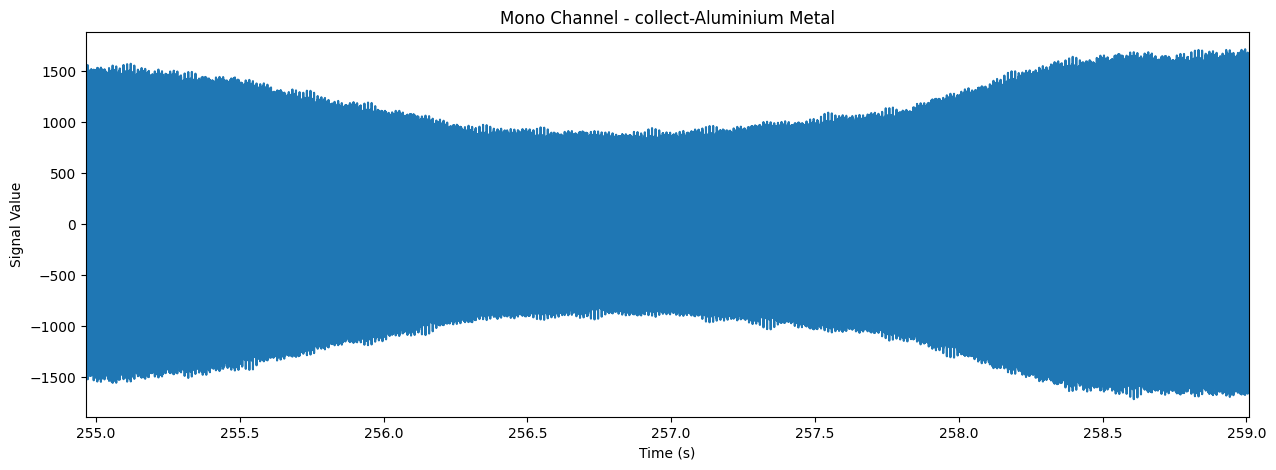

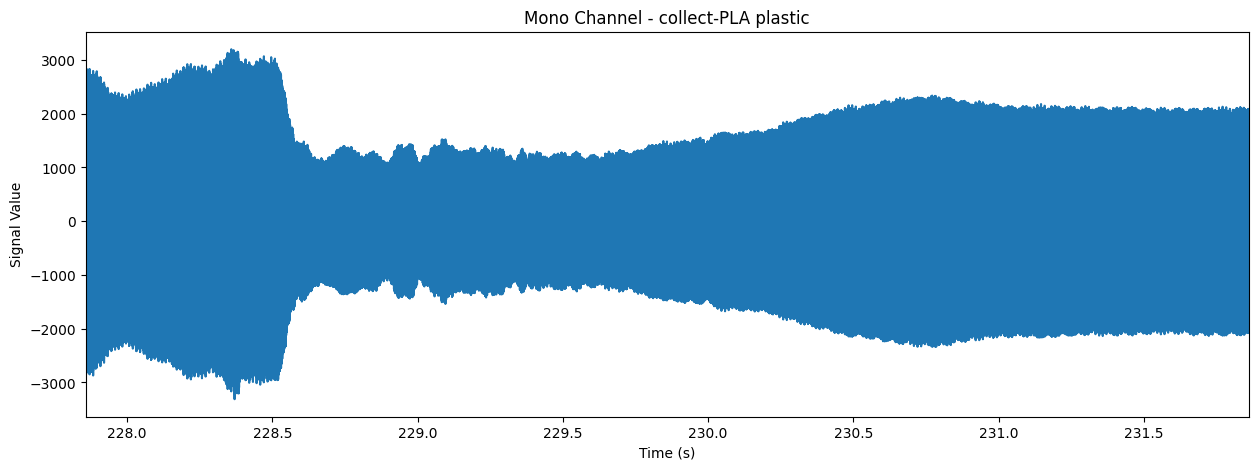

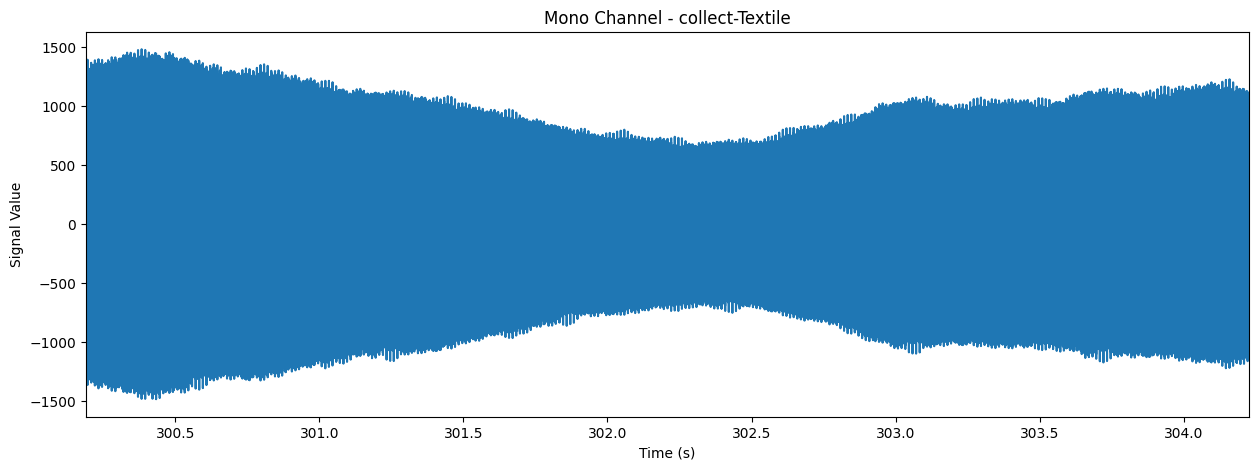

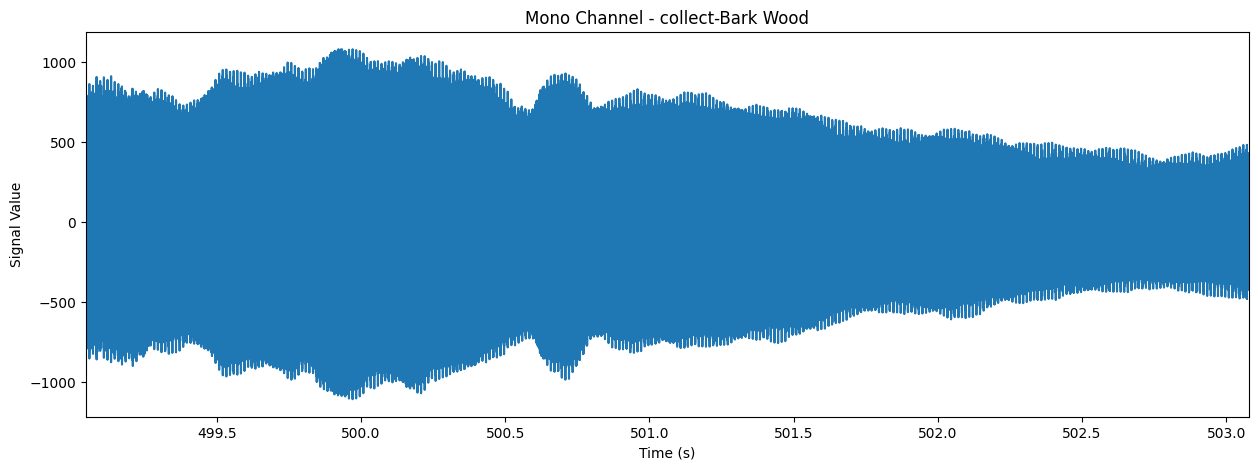

In [ ]:
# Plot the sound for the selected examples
plot_sound_selected(diff_labels)

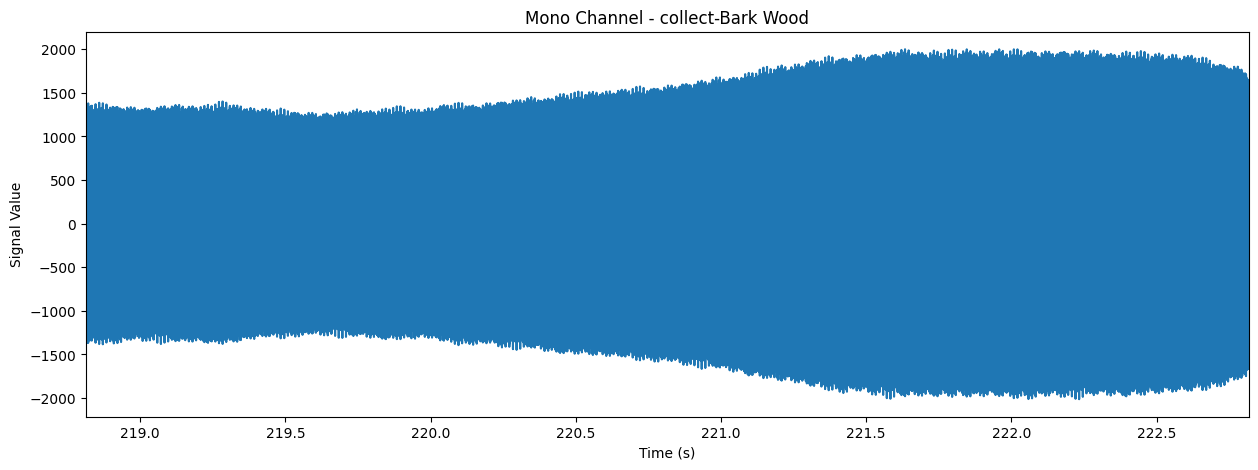

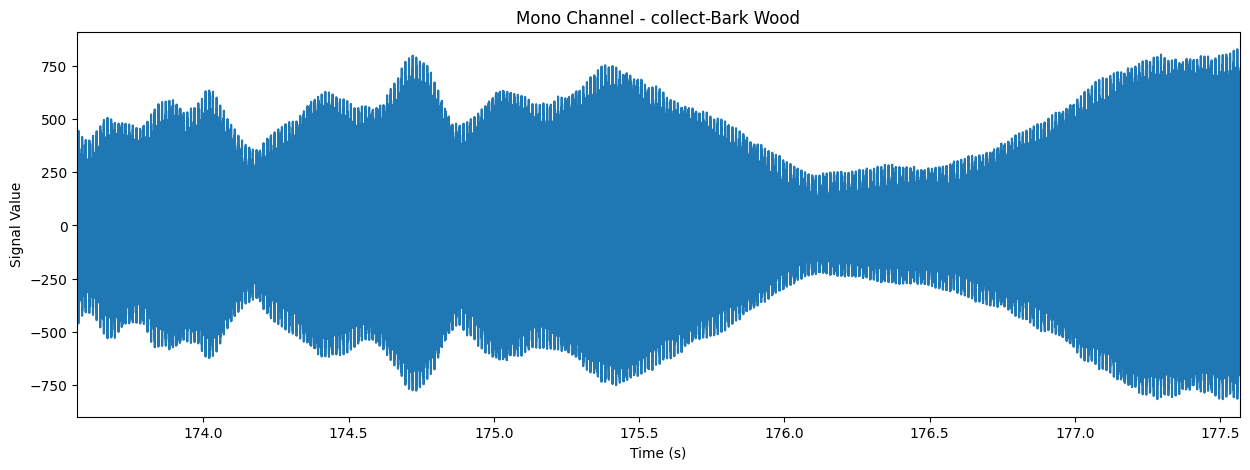

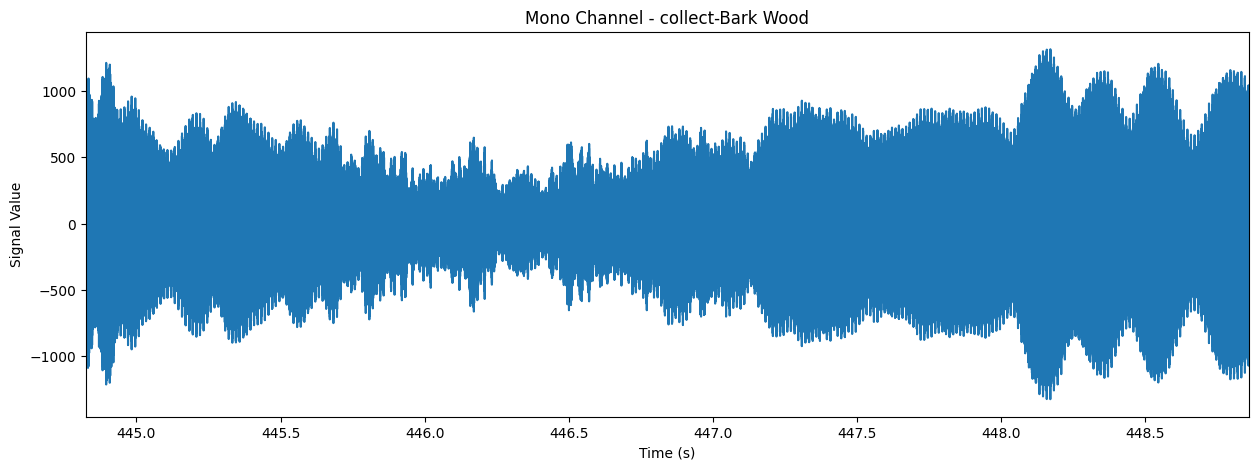

In [ ]:
label_to_select = "collect-Bark Wood"
matching_rows = collection_data[collection_data[:, 3] == label_to_select]
match_labels = matching_rows[np.random.choice(len(matching_rows), 3, replace=False)]
plot_sound_selected(match_labels)

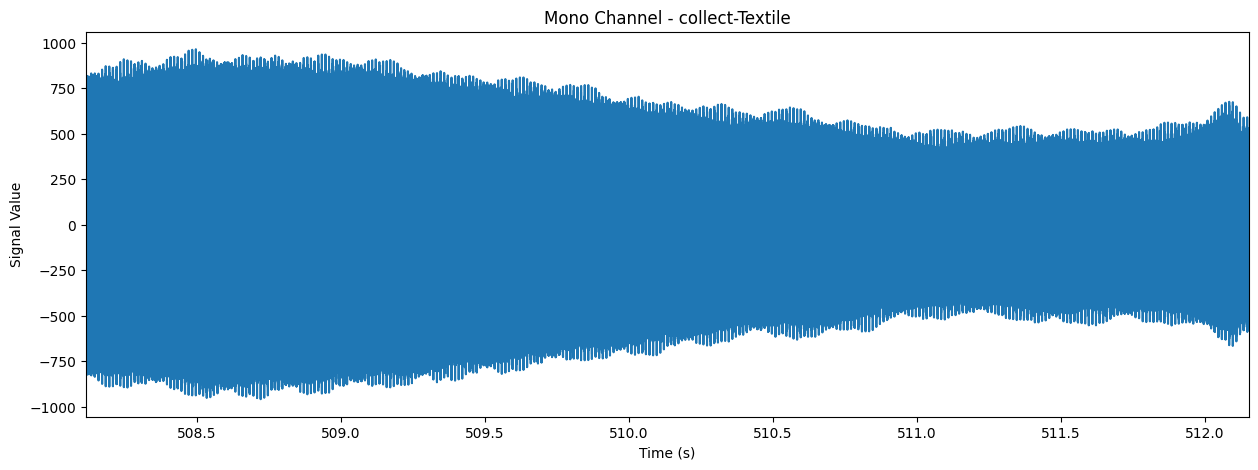

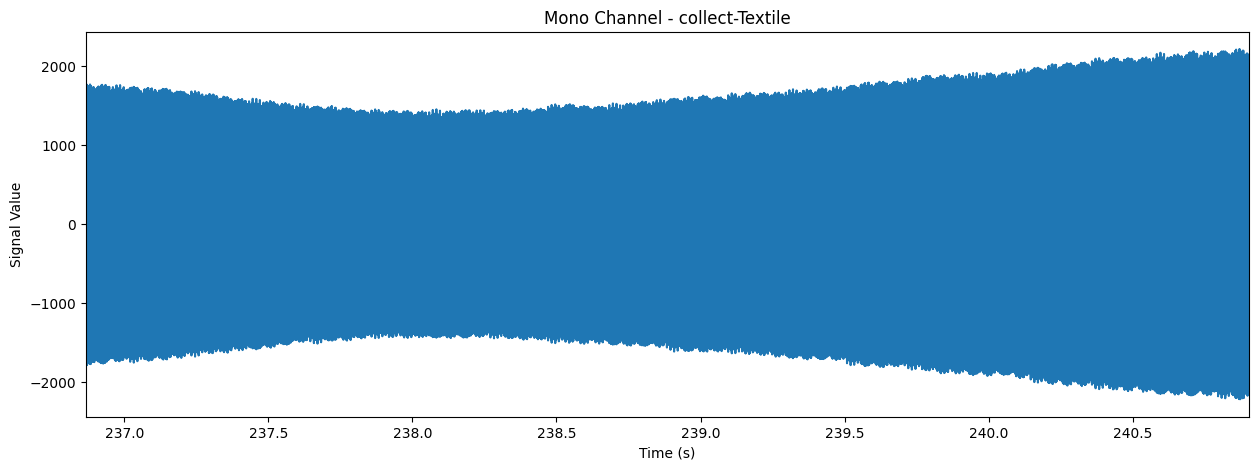

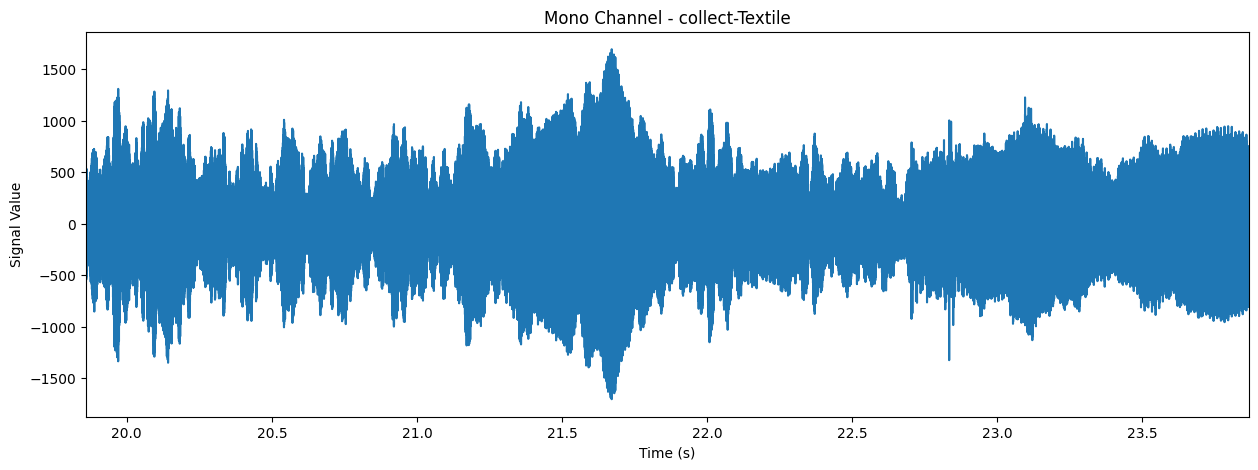

In [ ]:
label_to_select = "collect-Textile"
matching_rows = collection_data[collection_data[:, 3] == label_to_select]
match_labels = matching_rows[np.random.choice(len(matching_rows), 3, replace=False)]
plot_sound_selected(match_labels)

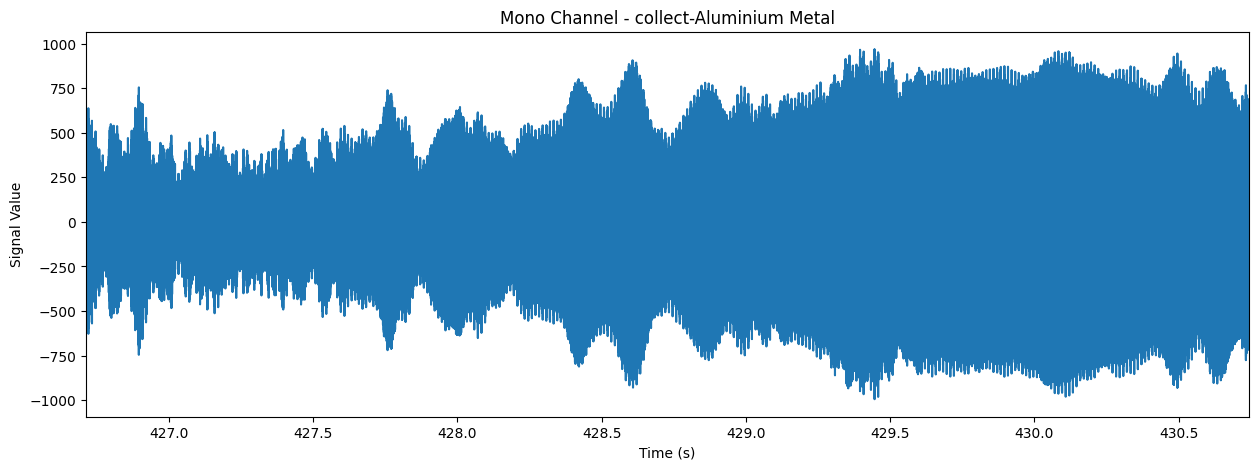

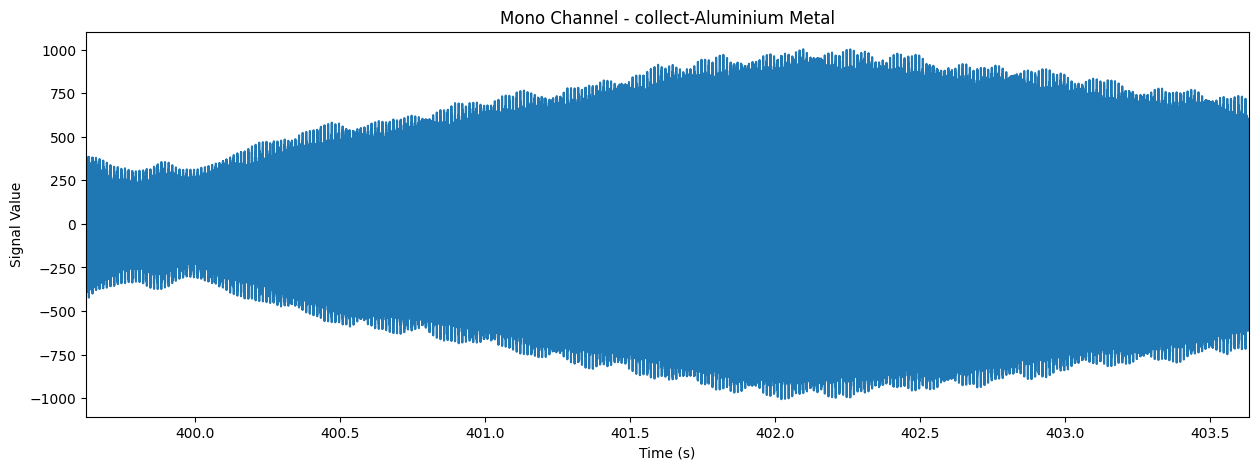

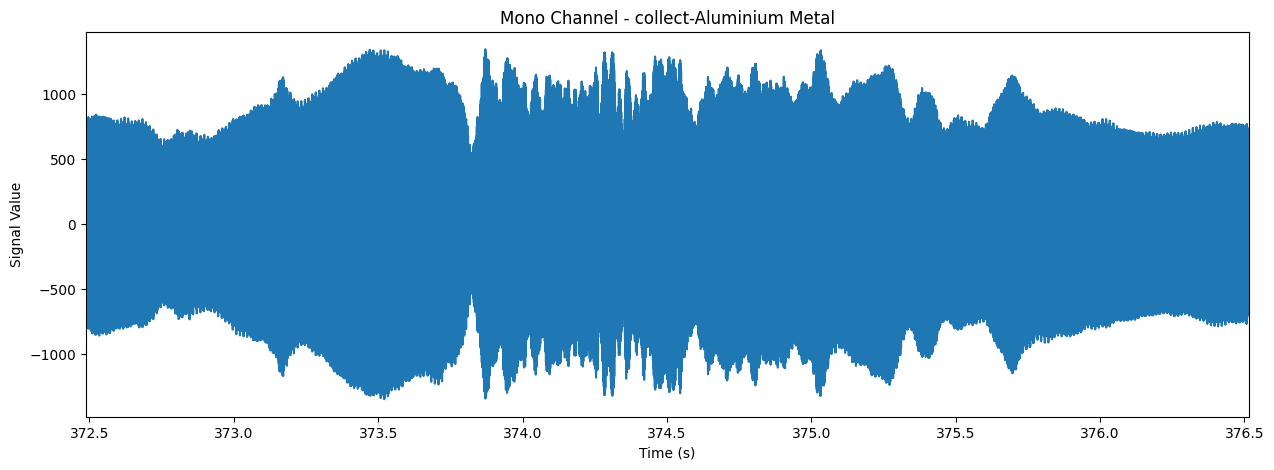

In [ ]:
label_to_select = "collect-Aluminium Metal"
matching_rows = collection_data[collection_data[:, 3] == label_to_select]
match_labels = matching_rows[np.random.choice(len(matching_rows), 3, replace=False)]
plot_sound_selected(match_labels)

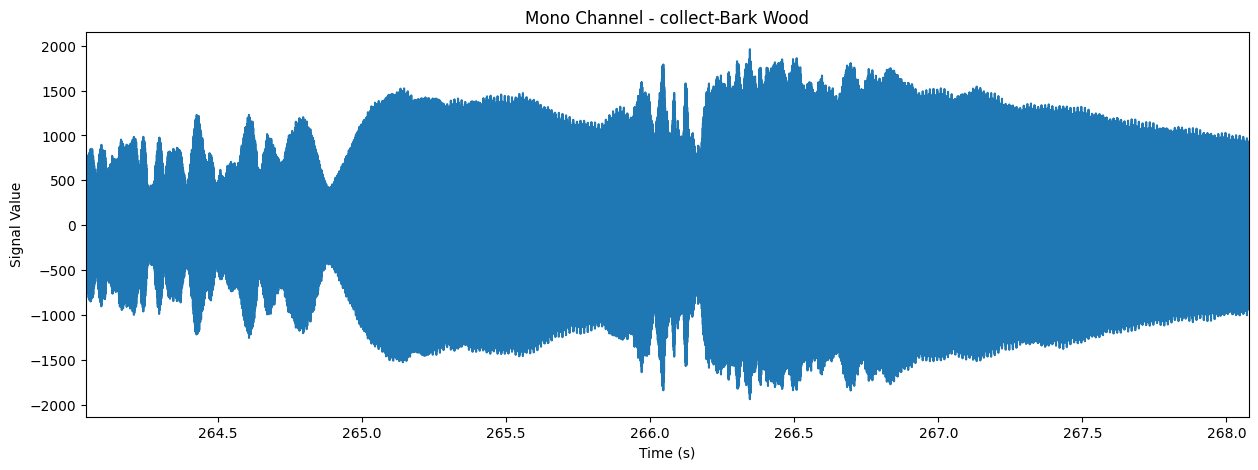

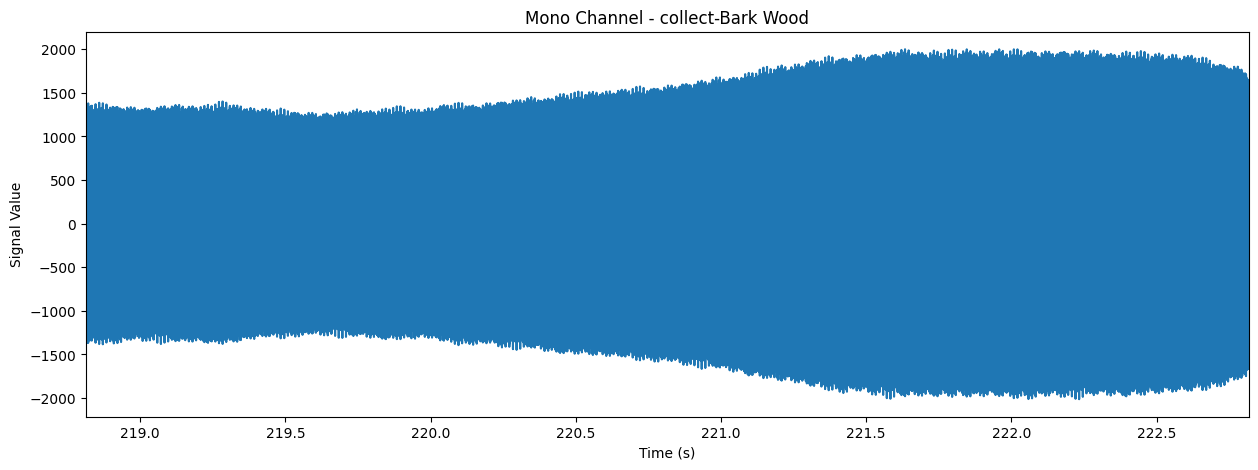

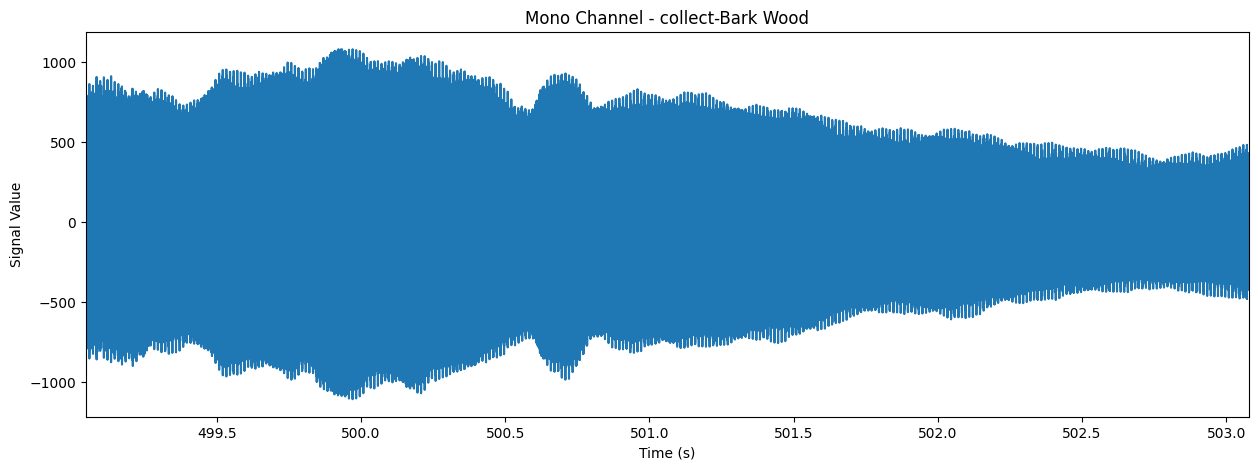

In [ ]:
label_to_select = "collect-Bark Wood"
matching_rows = collection_data[collection_data[:, 3] == label_to_select]
match_labels = matching_rows[np.random.choice(len(matching_rows), 3, replace=False)]
plot_sound_selected(match_labels)

In [ ]:
label_to_select = "collect-Table"
matching_rows = collection_data[collection_data[:, 3] == label_to_select]
match_labels = matching_rows[np.random.choice(len(matching_rows), 3, replace=False)]
plot_sound_selected(match_labels)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
# Creates a feature set that includes the mean amplitude, std dev and fourier transform of each of the segments as the features
# for the clustering algorithm
#
audio_features = []
for row in data:
    start_time = float(row[1])
    end_time = float(row[2])

    start_index = int(start_time * sample_rate)
    end_index = int(end_time * sample_rate)

    segment = mono_channel[start_index:end_index]

    mean_amplitude = np.mean(segment)
    std_amplitude = np.std(segment)
    fft_coefficients = np.abs(np.fft.fft(segment))[:10]

    features = [mean_amplitude, std_amplitude] + list(fft_coefficients)
    audio_features.append(features)

audio_features = np.array(audio_features)

In [ ]:
# DataFrame of features with labels
import pandas as pd
df = pd.DataFrame(audio_features, columns=['mean_amplitude', 'std_amplitude'] + [f'fft_{i}' for i in range(10)])
df['label'] = data[:, 3]
df['label'] = df['label'].astype(str)
df['label'] = df['label'].str.replace("collect-", "")

df.head()

In [ ]:
label_encoder = LabelEncoder()
true_labels = df['label'].values
encoded_labels = label_encoder.fit_transform(true_labels)

features = df.drop(columns=['label']).values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
for label in np.unique(encoded_labels):
    idx = np.where(encoded_labels == label)
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1],
                label=label_encoder.inverse_transform([label])[0])

plt.title("PCA of Audio Features Colored by True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="True Labels")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# K-MEANS CLUSTERING

scaler = StandardScaler()
scaled_features = scaler.fit_transform(audio_features)

n_clusters = len(labels_of_interest)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_features)

cluster_assignments = kmeans.labels_


In [ ]:
true_labels = df['label'].values

le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels_encoded, cluster_assignments)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()